In this notebook, we implement the two interior-point method for quadratic programming.
We show the progress of barrier method for QP and the tradeoff between the µ parameters and the iterations. 

In [94]:
import numpy as np
import pandas as pd
import numpy.linalg as linalg
import matplotlib.pyplot as plt

### Barrier method

In [101]:
def barrier_move_not_acceptable_for_qp(P, q, x, residual, f_val, v, f_prime, d_residual, s, t, alpha):
    moved = x + s * v
    moved_val = t * (.5 * np.matmul(np.matmul(moved.T, P), moved) + np.matmul(q.T, moved)) \
        - np.sum(np.log(residual + s * d_residual))
    return moved_val >= f_val + alpha * s * f_prime


def log_barrier_for_qp(P, q, A, b, alpha, beta, mu, iterations, tol=1e-3, eps=1e-4):

    t = 1
    gap = np.inf
    m = A.shape[0]
    n = A.shape[1]
    x = np.zeros((n, 1))
    gap_results = []

    for iteration in range(iterations):

        residual = (b - np.matmul(A, x)).astype('f')
        f_val = t * (.5 * np.matmul(x.T, np.matmul(P, x)) + np.matmul(q.T, x)) - np.sum(np.log(residual))
        f_grad = t * (np.matmul(P, x) + q) + np.matmul(A.T, np.reciprocal(residual))
        f_hess = t * P + np.matmul(A.T, np.matmul(np.diag(np.reciprocal(np.square(residual))[:, 0]), A))

        v = -1 * linalg.lstsq(f_hess, f_grad, rcond=None)[0]
        f_prime = np.matmul(f_grad.T, v)
        d_residual = -np.matmul(A, v)
        s = 1
        while np.min(residual + s * d_residual) <= 0:
            s *= beta
        while barrier_move_not_acceptable_for_qp(P, q, x, residual, f_val, v, f_prime, d_residual, s, t, alpha):
            s *= beta
            if s == 0:
                break

        x += s * v
        if -f_prime < eps:
            gap = m / t
            if gap < tol:
                print('Iteration: %d - final gap: %f' % (iteration, gap))
                gap_results.append(gap)
                break
            t = mu * t
        gap_results.append(gap)

    return gap_results

In [121]:
n = 10
m = 20
p_helper = np.random.rand(n, n)
P = np.dot(p_helper, p_helper.T)
q = np.random.rand(n, 1)
A = np.random.rand(m, n)
b = np.random.rand(m, 1)

Iteration: 57 - final gap: 0.000256
Iteration: 39 - final gap: 0.000200
Iteration: 32 - final gap: 0.000160
Iteration: 37 - final gap: 0.000020
Iteration: 30 - final gap: 0.000500
Iteration: 33 - final gap: 0.000125
[58, 40, 33, 38, 31, 34]


Text(0.5, 1.0, 'Progress of Barrier Method for a QP')

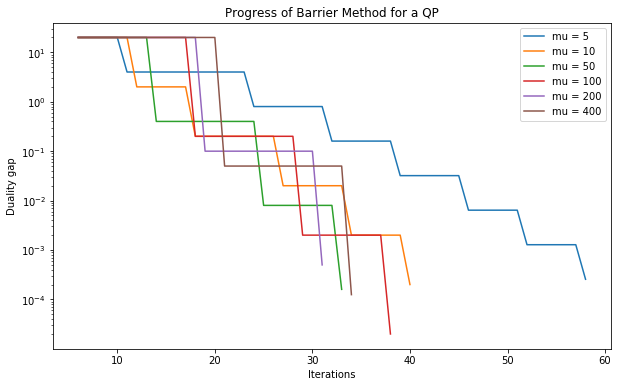

In [122]:
mu_list = [5,10,50,100,200,400]
plt.figure(figsize=(10,6)) 
iters_record = []
for mu in mu_list:
    gaps = log_barrier_for_qp(P, q, A, b, alpha=0.01, beta=0.5, mu=mu, iterations=200)
    iters = len(gaps)
    plt.plot(list(range(1, len(gaps) + 1)), gaps,label="mu = "+str(mu) ) 
    iters_record.append(iters)
print(iters_record)
plt.yscale('log')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Duality gap')
plt.title('Progress of Barrier Method for a QP')
    



No handles with labels found to put in legend.


Text(0.5, 1.0, 'Tradeoff of $\\mu$ Parameter for QP(Barrier method)')

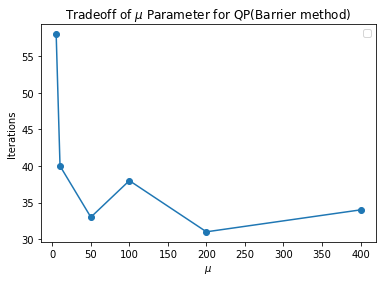

In [123]:
plt.scatter(mu_list, iters_record)
plt.plot(mu_list, iters_record)   
plt.legend()
plt.xlabel('$\mu$')
plt.ylabel('Iterations')
plt.title('Tradeoff of $\mu$ Parameter for QP(Barrier method)')

### Primal-dual method

In [124]:
def calculate_new_r(P, q, A, t_inv, step, z, dz, x, dx, s, ds):
    newz = z + step * dz
    newx = x + step * dx
    news = s + step * ds
    return np.concatenate((np.matmul(P, newx) + q + np.matmul(A.T, newz), newz * news - t_inv), axis=0)


def interior_point_for_qp(P, q, A, b, alpha, beta, mu, iterations, tol=1e-3, eps=1e-3):

    m = A.shape[0]
    n = A.shape[1]
    x = np.zeros((n, 1))
    s = (b - np.matmul(A, x)).astype('f')
    z = np.reciprocal(s)
    surrogates = []
    dual_residual_norms = []

    for iteration in range(iterations):

        gap = np.asscalar(np.matmul(s.T, z))
        res = np.matmul(P, x) + q + np.matmul(A.T, z)
        surrogates.append(gap)
        dual_residual_norms.append(linalg.norm(res))
        if (gap < tol) and (linalg.norm(res) < eps):
            break

        t_inv = gap / (m * mu)
        sol_a = -1 * np.concatenate(
            (np.concatenate((P, A.T), axis=1), np.concatenate((A, np.diag(-np.divide(s, z)[:, 0])), axis=1)), axis=0)
        sol_b = np.concatenate((res, -s + t_inv * np.reciprocal(z)), axis=0)
        sol = linalg.lstsq(sol_a, sol_b, rcond=None)[0]

        dx = sol[0:n, :]
        dz = sol[n:n+m, :]
        ds = np.matmul(-A, dx)
        r = np.concatenate((res, z*s - t_inv), axis=0)

        step = min(1.0, 0.99 / np.max(np.divide(-dz, z)))
        while np.min(s + step * ds) <= 0:
            step *= beta
            if step == 0:
                break
        while linalg.norm(calculate_new_r(P, q, A, t_inv, step, z, dz, x, dx, s, ds)) > (1-alpha*step) * linalg.norm(r):
            step *= beta
            if step == 0:
                break

        x += step * dx
        z += step * dz
        s = b - np.matmul(A, x)

    return surrogates, dual_residual_norms

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


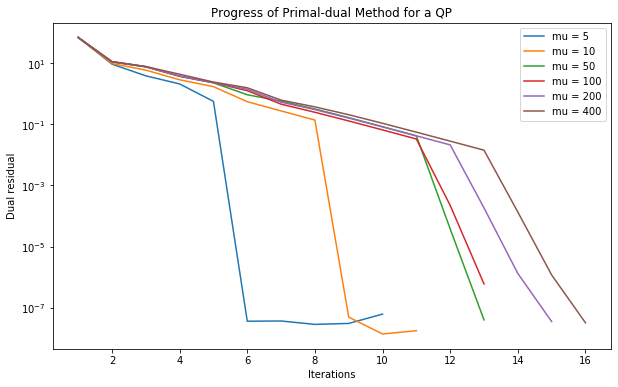

In [125]:
mu_list = [5,10,50,100,200,400]
plt.figure(figsize=(10,6)) 
iters_record = []
for mu in mu_list:
    surrogates, dual_residuals = interior_point_for_qp(P, q, A, b, alpha=0.01, beta=0.5, mu=mu, iterations=300, tol=1e-4, eps=1e-6)
    iterations = list(range(1, len(dual_residuals) + 1))
    iters_record.append(len(dual_residuals))
    plt.plot(iterations, dual_residuals,label="mu = "+str(mu))
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Dual residual')
plt.title('Progress of Primal-dual Method for a QP')
plt.legend()
plt.show()

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Tradeoff of $\\mu$ Parameter for QP (primal-dual method)')

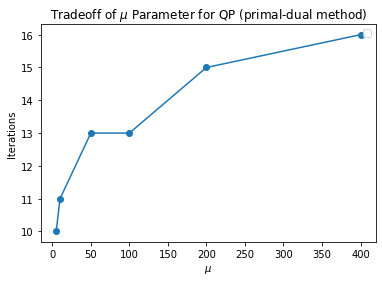

In [126]:
plt.scatter(mu_list, iters_record)
plt.plot(mu_list, iters_record)   
plt.legend()
plt.xlabel('$\mu$')
plt.ylabel('Iterations')
plt.title('Tradeoff of $\mu$ Parameter for QP (primal-dual method)')